# **IMPORTADO DE MÓDULOS/FUNCTIONS**

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import torch

In [2]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')
REALS = np.concatenate((V28, V55, V82), axis = 0)

In [3]:
data = np.load('/home/josea/PRUEBA_Co60.npz')['data']

In [4]:
from functions import (gauss, gauss_fit, create_and_delay_pulse_pair, create_position, calculate_gaussian_center_sigma, 
                       plot_gaussian_and_get_params, set_seed)
from Models import ConvolutionalModel, train_loop_convolutional

2024-08-28 18:37:41.080282: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 18:37:41.105187: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 18:37:41.489560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **INTERPOLACION**

In [5]:
#--------------------------------Interpolar pulsos reales---------------------------------
EXTRASAMPLING = 8
Nt = np.shape(REALS)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_REALS = interp1d(tiempo, REALS, kind = 'cubic', axis = 1)
new_REALS = interp_func_REALS(tiempo_new)

interp_func_data = interp1d(tiempo, data,  kind='cubic', axis=1)
new_data = interp_func_data(tiempo_new)

#---------------------------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_data[:,:,1] = np.roll(new_data[:,:,1], align_steps)
new_data[:,:align_steps,1] = np.random.normal(scale = 1e-6, size = align_steps)


#----------------------------------------------------- Print important information -----------------------------------
print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [6]:
delay_steps = 30  # Max number of steps to delay pulses
nbins = 51  # Num bins for all histograms                          
t_shift = 8  # Time steps to move for the new positions
start = 50*EXTRASAMPLING
stop = 74*EXTRASAMPLING
set_seed(42) #Fix seeds
epochs = 500 
lr = 1e-4

#new_data= new_data[np.random.permutation(new_data.shape[0]), :, :]
# Train/test set split
train_data = new_data[:3800,:,:]
test_data = new_data[3800:,:,:]
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  3800
Número de casos de test:  656


# **SINGLES TRAINING**

In [7]:
#---------------------------------------------- Move to reference pulse --------------------------------
#mean_pulse_dec0 = get_mean_pulse_from_set(train_data, channel = 0)
#mean_pulse_dec1 = get_mean_pulse_from_set(train_data, channel = 1)

#delays_train_dec0 , moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
#delays_train_dec1 , moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 1)

#train_dec0, REF_train_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = delay_steps , NOISE = True)
#train_dec1, REF_train_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = delay_steps , NOISE = True)


#---------------------------------------------- Delay real pulses --------------------------------
train_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,start:stop,0], new_time_step, delay_steps = delay_steps, NOISE = True)
train_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,start:stop,1], new_time_step, delay_steps = delay_steps, NOISE = True)

## **FULL TOF**

In [8]:
#--------------------------------------- Move pulses to a reference one -------------------------------------------------
#delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, validation_data, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
#delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, validation_data, start = start, stop = stop, max_delay = int(stop-start), channel = 1)


#TEST_00 = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
TEST_00 = test_data[:,start:stop,:]
TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)  
TEST = np.concatenate((TEST_02, TEST_00, TEST_20), axis = 0)

In [9]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

In [10]:
model_dec0 = ConvolutionalModel(int(stop-start))
model_dec1 = ConvolutionalModel(int(stop-start))

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = lr) 
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = lr) 

#Execute train loop
loss_dec0, test_dec0 = train_loop_convolutional(model_dec0, optimizer_dec0, train_loader_dec0, torch.tensor(TEST[:,:,0]).float(), EPOCHS = epochs, save = False) 
loss_dec1, test_dec1 = train_loop_convolutional(model_dec1, optimizer_dec1, train_loader_dec1, torch.tensor(TEST[:,:,1]).float(), EPOCHS = epochs, save = False)

/home/josea/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/josea/.local/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


EPOCH 1: LOSS train 0.08499185542055106
EPOCH 2: LOSS train 0.034039505291730165
EPOCH 3: LOSS train 0.010642624727521345
EPOCH 4: LOSS train 0.009088730559905328
EPOCH 5: LOSS train 0.005858610574574352
EPOCH 6: LOSS train 0.004821675397471478
EPOCH 7: LOSS train 0.004243043952787263
EPOCH 8: LOSS train 0.003960462657032314
EPOCH 9: LOSS train 0.008292235231808371
EPOCH 10: LOSS train 0.0032780121353857407
EPOCH 11: LOSS train 0.0031621388798003416
EPOCH 12: LOSS train 0.0028539834908107137
EPOCH 13: LOSS train 0.002468878228436382
EPOCH 14: LOSS train 0.001817840499748176
EPOCH 15: LOSS train 0.0016771545272342213
EPOCH 16: LOSS train 0.0014748444363388029
EPOCH 17: LOSS train 0.001201677112938773
EPOCH 18: LOSS train 0.0009156975367844452
EPOCH 19: LOSS train 0.007944529232375671
EPOCH 20: LOSS train 0.0016739069512784798
EPOCH 21: LOSS train 0.0012316927497553387
EPOCH 22: LOSS train 0.0009658872988469647
EPOCH 23: LOSS train 0.0009260683404814483
EPOCH 24: LOSS train 0.00067522254

In [11]:
#if create_positions == 1:
#        TOFN_V28 = test_dec0[:,:V28.shape[0]] - test_dec1[:,:V28.shape[0]]
#        TOFN_V55 = test_dec0[:,V28.shape[0] :V28.shape[0] + V55.shape[0]] - test_dec1[:,V28.shape[0] :V28.shape[0] + V55.shape[0]]
#        TOFN_V82 = test_dec0[:,V28.shape[0] + V55.shape[0]:] - test_dec1[:,V28.shape[0] + V55.shape[0]:]
#
#if create_positions == 0:
TOFN_V02 = test_dec0[:,:TEST_00.shape[0]] - test_dec1[:,:TEST_00.shape[0]]
TOFN_V00 = test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - test_dec1[:, TEST_00.shape[0] : 2*TEST_00.shape[0]]
TOFN_V20 = test_dec0[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]] - test_dec1[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]]
#TOFN_V04 = test_dec0[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]] - test_dec1[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]]
#TOFN_V40 = test_dec0[:,4*TEST_00.shape[0]:] - test_dec1[:,4*TEST_00.shape[0]:]

# Calulate Validation error
#if create_positions == 1:
#    
#    # Calculate centered position 'centroid'
#    centroid_V55, sigmaN_V55 = calculate_gaussian_center_sigma(TOFN_V55, np.zeros((TOFN_V55.shape[0])),  nbins = nbins)  
#    
#    error_V28 = abs((TOFN_V28 - centroid_V55[:, np.newaxis] + 0.2))
#    error_V55 = abs((TOFN_V55 - centroid_V55[:, np.newaxis]))
#    error_V82 = abs((TOFN_V82 - centroid_V55[:, np.newaxis] - 0.2))
#    Error = np.concatenate((error_V28, error_V55, error_V82), axis = 1)

#if create_positions == 0:
# Calculate centered position 'centroid'
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOFN_V00, np.zeros((TOFN_V00.shape[0])), nbins = nbins) 
    
error_V02 = abs((TOFN_V02 - centroid_V00[:, np.newaxis] + 0.2))
error_V00 = abs((TOFN_V00 - centroid_V00[:, np.newaxis]))
error_V20 = abs((TOFN_V20 - centroid_V00[:, np.newaxis] - 0.2))
#error_V04 = abs((TOFN_V04 - centroid_V00[:, np.newaxis] + 0.4))
#error_V40 = abs((TOFN_V40 - centroid_V00[:, np.newaxis] - 0.4))

#Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)
Error = np.concatenate((error_V02, error_V00, error_V20), axis = 1)    

287 0.07362941332468817


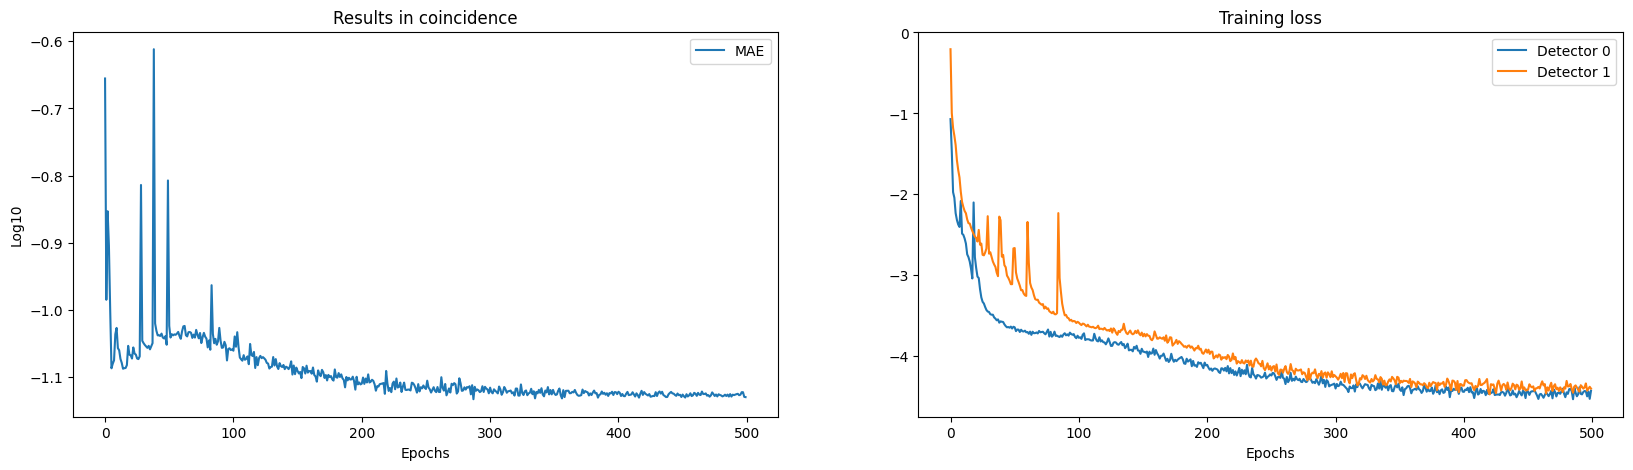

In [12]:
# Print MAE
MAE = np.mean(Error, axis = 1)
idx_min_MAE = np.where(MAE == np.min(MAE))[0][0]
print(idx_min_MAE, np.min(MAE))


# PLot
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.plot(np.log10(MAE.astype('float64')), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()


plt.subplot(122)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()

plt.legend()


V02: CENTROID(ns) = -0.196  FWHM(ns) = 0.223  std(ns) = 0.095
V00: CENTROID(ns) = 0.000  FWHM(ns) = 0.190  std(ns) = 0.081
V20: CENTROID(ns) = 0.185  FWHM(ns) = 0.229  std(ns) = 0.097


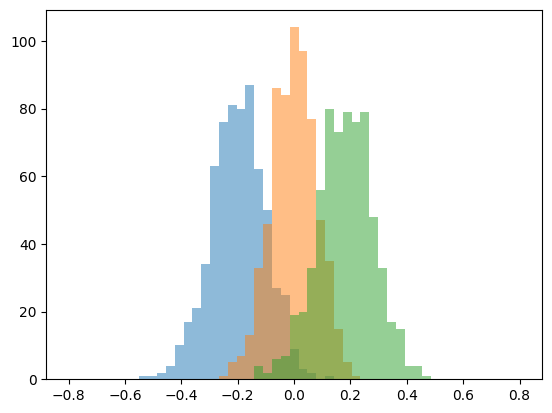

In [13]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
HN, AN, x0N_V02, sigmaN_V02, FWHMN_V02 = plot_gaussian_and_get_params(TOFN_V02[idx_min_MAE,:], centroid_V00[idx_min_MAE], range = 0.8, label = '-0.4 ns offset', nbins = nbins)
HN, AN, x0N_V00, sigmaN_V00, FWHMN_V00 = plot_gaussian_and_get_params(TOFN_V00[idx_min_MAE,:], centroid_V00[idx_min_MAE], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
HN, AN, x0N_V20, sigmaN_V20, FWHMN_V20 = plot_gaussian_and_get_params(TOFN_V20[idx_min_MAE,:], centroid_V00[idx_min_MAE], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
   
print('')
print("V02: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V02, FWHMN_V02, sigmaN_V02))
print("V00: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V00, FWHMN_V00, sigmaN_V00))
print("V20: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V20, FWHMN_V20, sigmaN_V20))